In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize, Bounds
import matplotlib.pyplot as plt
from datetime import datetime,date

from tqdm.notebook import tqdm_notebook
import math
import time
import pyfolio as pf
%matplotlib inline

C:\Users\Amaury\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [5]:
def get_data(assets, start_date, end_date, time_interval):
    return yf.download(assets, 
                          start = start_date, 
                          end = end_date,
                          interval = time_interval,
                          threads = True,
                          progress = False)['Adj Close']

In [6]:
assets  = [ 'SPY', "QQQ", "VGK", "SCZ", "EWJ", "EEM", #eq
           'REM', "VNQ", "RWX", # re
           'TIP', "IEF", "TLT", "BWX", #fi
           'DBC', "GLD", #como
           'twtr', 'intc', 'tsm',"VWUSX", "Amc"]


# ----------- DATES ------
start_train_date = '2020-01-01'
end_train_date = '2021-01-01'
start_test_date = end_train_date
end_test_date = date.today()
interval = "1d"


all_stocks = get_data(assets, '2014-01-01', '2022-01-01', "1d")

"""returns = np.log(all_stocks/all_stocks.shift(1))
returns.fillna(0)
returns_raw = returns.iloc[1: , :]

int((returns_raw.shape[0]-253)/20)"""

'returns = np.log(all_stocks/all_stocks.shift(1))\nreturns.fillna(0)\nreturns_raw = returns.iloc[1: , :]\n\nint((returns_raw.shape[0]-253)/20)'

Initialisation des variables

In [7]:
def init(Money, periode_trades):
    
    global memo, X, cash, argent_gagne, couts_transaction, s, argent_fait, pf_value, pos, pos2, bounds, nb_actifs, returns_raw
    
    # Variables utilisées dans l'algorithme

    returns = np.log(all_stocks/all_stocks.shift(periode_trades))
    returns.fillna(0)
    returns_raw = returns.iloc[periode_trades: , :]
    
    cash = Money
    win = 0
    argent_gagne = 0
    cout = 0
    couts_transaction = 0
    s = 0
    nb_actifs = returns_raw.shape[1]
    argent_fait = [Money]
    pf_value = 0
    X = []
    memo = {}

    # pos = portefeuille initialement vide
    pos = np.array([0 for i in range(nb_actifs)])
    


Fonctions objectif et coûts de transaction

In [8]:
def objective_cov(pos, returns, covar_matrix, alpha,lamb, memoisation, pospre,vp):
    global s
    if memoisation:
        x = str(pos)
        if x not in memo:
            s = pos@covar_matrix@pos - alpha*returns@pos +lamb*TC(pospre,pos,vp)
            memo[x] = s
        else:
            s = memo[x]
            # print("la mémo a été utile")
    else:
        s = pos@covar_matrix@pos - alpha*returns@pos +lamb*TC(pospre,pos,vp)
    
    # print(f"Valeur de la fonction objectif : {s.round(3)}")
    return s

def TC(pos,pos2, vp):
    return (np.sum(np.array([np.abs((pos2[i]-pos[i])) for i in range(nb_actifs)])))


Import des données roulantes à l'étape i

In [9]:
def import_donnees(etape):
    global X
    
    # import des données roulantes, on calcule à partir des données de l'année précédente
    log_returns = returns_raw.iloc[etape:253+etape, :]
    # calcul des expected returns (par Standard Moving Average, et on prend une période plus courte)
    expected_returns_SMA = log_returns.iloc[-jours_returns:: ,:].mean()
    # calcul des expected returns (par Exponential Moving Average)
    expected_returns_EMA = log_returns.iloc[-jours_returns*3:: ,:].ewm(span=jours_returns, adjust=False).mean().iloc[-1,:]
    
    # calcul de la matrice de covariance
    covar = log_returns.cov().copy()
    covar_matrix = covar.to_numpy()
    
    correl = log_returns.corr().copy()
    correl_matrix = correl.to_numpy()

    # calcul du vecteur prix des actifs à t (le temps de la décision) et t + 1jour
    vp = all_stocks[253+etape::].values[0]
    vp2 = all_stocks[253+etape+periode_trades::].values[0]
    
    expected_returns = np.array([expected_returns_EMA[i]*vp[i] for i in range(nb_actifs)])

    #X.append(str(returns_raw.iloc[253+etape].name).split()[0])
    #print(str(log_returns.iloc[-1].name).split()[0])
    memo = {}
    
    return expected_returns, covar_matrix, vp, vp2, memo

Fonctions contraintes

In [42]:
#def cons1(x,Money,vp):
    # on ne peut pas investir plus que ce qu'on possède
    #return Money - np.sum([x[i]*vp[i] for i in range(nb_actifs)])

def cons2(x,cash,pos,vp,lamb):
    # pour payer les coûts de transaction, il faut soit utiliser du cash soit vendre des positions (pour un prix -delta_P*vp)
    return cash + np.sum([(pos[i]-x[i])*vp[i] for i in range(nb_actifs)]) - lamb*TC(pos,x,vp)

def cons3(x,returns,vp, gain_cible):
    # on veut au moins que le gain soit supérieur à gain_cible
    return np.sum([returns[i]*vp[i]*x[i] for i in range(nb_actifs)]) - gain_cible
def cons4(x,pos,dPmax):
    return dPmax-max([abs(x[i]-pos[i]) for i in range (nb_actifs)])

def cons4bis(x,pos,dPmax):
    # pour chaque actif, on ne peut en changer (en notionnel) plus de dPmax% de la valeur déjà investie dans l'actif
    return min([dPmax*abs(pos[i]) - abs(x[i]-pos[i]) for i in range (nb_actifs)])

def cons5(x,pos,dNmax,pf2_value,vp):
    # on doit avoir abs(pf_value_T+1 - pf_value_T)/pf_value_T <= dNmax
    return dN_max*abs(pf2_value) - abs(np.sum([(pos[i]-x[i])*vp[i] for i in range(nb_actifs)]))

def cons_long(x):
    return min(x)

Calcul de l'optimisation roulante

In [111]:
D_lambd = []
D = []
def compute_portfolio(lamb, alpha, Money, Pos_max_par_actif, jours_returns, periode_trades, nb_etapes, gain_cible, debug=True):
    

    global pf_value, pos, pos2, argent_gagne, cout, win, cash, couts_transaction, pospre
    global Test_pos, Test_TC, Test_money, Test_cash, TCs, Moneys, Cashs
    
    init(Money, periode_trades)
    Test_pos = [[0 for i in range(nb_actifs)]]
    Test_TC = [0]
    Test_money = [0]
    Test_cash = [0]
    TCs = [0]
    Moneys = [0]
    Cashs = [0]
    if debug:
        print("Argent injecté au départ:", Money)


    for i in tqdm_notebook(range(min(nb_etapes,int((returns_raw.shape[0]-253)/periode_trades)))):

        # calcul des returns, de la matrice de variance, des vecteurs prix
        returns, covar_matrix, vp, vp2, memo = import_donnees(i*periode_trades)

        cons = (#{"type":"ineq", "fun": lambda x: cons1(x,Money,vp)}, --> contrainte finalement inutile vis à vis de la seconde
               #{"type": "ineq", "fun": lambda x: cons2(x,cash,pos,vp,lamb)},
               #{"type": "ineq", "fun": lambda x: cons3(x,returns,vp, gain_cible)},
                #{"type": "ineq", "fun": lambda x: cons4(x,pos,dPmax)},
                {"type": "ineq", "fun": lambda x: cons4bis(x,pos,dPmax)}
                #{"type": "ineq", "fun": lambda x: cons_long(x)}
            
               )
        
        #bounds = Bounds(0, 10000000)
        
        # calcul du vecteur position
        p = minimize(objective_cov, pos, 
                 method = "COBYLA",
                 #bounds = bounds,
                 constraints = cons,
                args=(returns, covar_matrix, alpha,lamb, memoisation, pos,vp),
                options={'maxiter': 300, 'ftol':1e-10})
        if not p.success:
            print("False",p.message)
            #newpos=pos
        newpos=p.x
            
        cout = lamb*TC(pos,newpos, vp)
        
        TCs.append(cout)
        
        """
        print(cons1(p.x,Money,vp))
        print(cons2(p.x,cash,pos,vp))
        print("gain espéré",cons3(p.x,returns,vp,gain_cible)+gain_cible)"""
        
        couts_transaction += cout

        pos = newpos # les positions prises en fin de journée
        
        pf2_value = np.sum([pos[i]*vp[i] for i in range(nb_actifs)])


        cash_restant = Money - (pf2_value + cout) # = valeur totale à t-1 - argent ivesti à t
        cash = cash_restant # l'argent que l'algo décide de ne pas investir
        
        Cashs.append(cash)

        if debug:
            print("\n","Etape {}:".format(i))

            # affichage des valeurs numériques
            print('\033[94m'+"Somme des positions: "+str(pf2_value)+'\033[0m')
            print('\033[92m'+"Coûts de transaction: "+str(cout)+'\033[0m')
            print("cash :", cash.round(6))
            print(f"La valeur de la fonction objectif:{s}")

        # mise à jour à chaque actualisation des prix
        pf_value = np.sum([pos[i]*vp2[i] for i in range(nb_actifs)])
        Money = pf_value + cash
        argent_fait.append(Money)
        D.append(argent_fait)
        D_lambd.append(argent_fait)
        win = pf_value - pf2_value
        argent_gagne += win
        if debug:
            print('\033[94m'+"Somme des positions: "+str(pf_value)+'\033[0m')
            print('\033[95m'+"Argent généré sans TC : "+str(win)+'\033[0m')
            print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")

        
        """print('\033[95m'+"Gain réel sans TC : "+str(win)+'\033[0m')
        print('\033[92m'+"Coûts de transaction: "+str(cout)+'\033[0m')
        print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")"""
        
    if debug:
        print("\n","fin du calcul")

    print('\033[95m'+"Argent total généré sans TC : "+str(argent_gagne)+'\033[0m')
    print('\033[92m'+"Coûts totaux de transaction: "+str(couts_transaction)+'\033[0m')
    print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")


False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

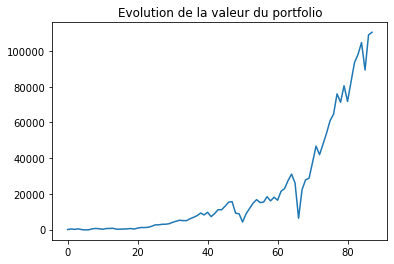

In [91]:
# Paramètres modifiables

lamb = 0.01 # Coûts de transaction ; faire attention car sinon il n'y a pas de mouvements de position
alpha = 1 # importance accordée à l'expected return
Money = 0 # argent alloué pour l'investissement initial
Pos_max_par_actif = 10000 # quantité maximale d'argent investi par actif
jours_returns = 10 # les n derniers jours qui servent pour calculer les expected returns
periode_trades = 20 # le nombre de jours ouvrés qui séparent chaque décision
memoisation = True
dPmax = 10
gain_cible = 0.015
fact=10000

start = time.time()
compute_portfolio(lamb, alpha, Money, Pos_max_par_actif, jours_returns, periode_trades,999, gain_cible, False)
end = time.time()
print('\033[90m'+"Temps d'exécution: "+format(end-start)+'\033[0m')


plt.plot(argent_fait)
plt.title("Evolution de la valeur du portfolio")
plt.show()

In [86]:
print("Pente moyenne :", int(10000*argent_fait[-1]/(25))/10000,"par période")
L=[]
print(argent_fait)
for i in range(2,25):
    L.append((argent_fait[i]-argent_fait[i-1])/argent_fait[i-1])
test = np.array(L)
print(np.mean(test))
print(L)

Pente moyenne : 4423.9527 par période
[0, 289.567812530453, 69.36933466681648, 383.9496943422847, -45.37608179867851, -228.1061110650716, -168.9912372475037, 373.5624299499368, 596.7516900988649, 431.7334249219084, 153.1397124035875, 538.1061002902388, 608.412191478234, 663.5552660151252, 162.88120645402887, 213.5760107221804, 271.77114334070075, 382.1208909220277, 569.9289558372802, 240.910138037646, 785.5108247922217, 1119.1638774222083, 1104.5886497032243, 1231.720923790147, 1814.3259173374145, 2587.3276756611513, 2623.1423611984546, 2924.4211556003465, 2961.076004784485, 3249.1878389366957, 4010.350648823609, 4641.551827226831, 5209.457965900117, 4961.207698619335, 4999.17759774319, 6050.3821576446535, 6850.564988477276, 7760.377289297703, 9213.205535402307, 8172.907077148, 9664.42590459975, 7229.780193469709, 8897.24101766117, 11116.46644892632, 11067.572983435148, 13064.268479767154, 15314.433987647826, 15624.942222523961, 9148.042140337617, 8798.2677966548, 4206.232498009464, 88

Test

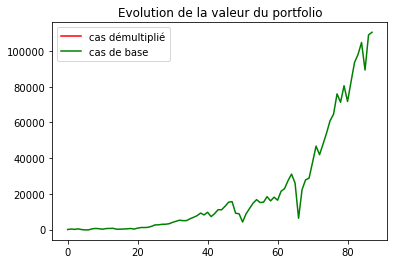

In [87]:
plt.plot(Test_money,'r', label="cas démultiplié")
plt.plot(argent_fait,'g', label="cas de base")
plt.legend()
plt.title("Evolution de la valeur du portfolio")
plt.show()

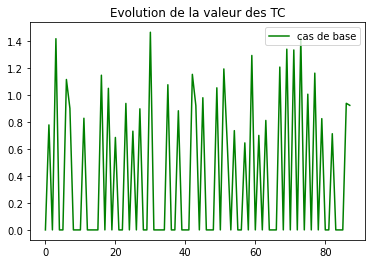

In [88]:
#plt.plot(Test_TC,'r', label="cas démultiplié")
plt.plot([TCs[i] for i in range(len(TCs))],'g', label="cas de base")
plt.legend()
plt.title("Evolution de la valeur des TC")
plt.show()

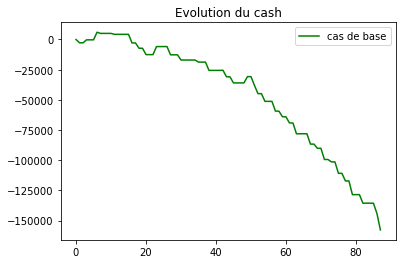

In [89]:
#plt.plot(Test_cash,'r', label="cas démultiplié")
plt.plot([Cashs[i] for i in range(len(Cashs))],'g', label="cas de base")
plt.legend()
plt.title("Evolution du cash")
plt.show()

Calcul du drawdown

In [76]:
drawdown = -math.inf
maxi = -math.inf
mini = math.inf
i = 0
details = False # afficher plus de détails

for x in argent_fait:
    if x > maxi:
        if details :
            print("max atteint en{}:{}".format(i, argent_fait[i]) )
        maxi = x
        mini = math.inf
    elif x < mini:
        if details:
            print("min atteint en{}:{}".format(i, argent_fait[i]) )
        mini = x
        if maxi != 0:
            drawdown = max(drawdown, (maxi-mini)/maxi)
    i+=1

drawdown

0.7280291005635069

In [77]:
pos.round(3)

array([ 4.07900e+00,  2.65000e+01,  6.19700e+00, -1.44400e+00,
        3.57780e+01,  2.51024e+02,  1.13800e+02, -7.14000e-01,
        5.88448e+02, -1.47400e+00, -1.29400e+00,  1.92000e-01,
        9.86165e+02,  1.37307e+02,  2.14032e+02, -1.37000e+00,
       -1.49000e+00, -7.61000e-01,  6.16070e+01, -1.44300e+00])

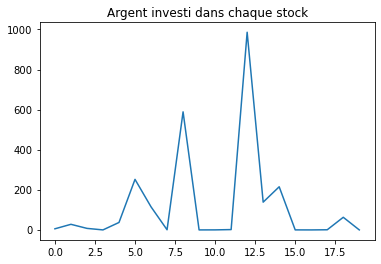

L'argent est le plus investi dans l'action: BWX


In [78]:
plt.plot([pos[i] for i in range(len(pos))])
plt.title("Argent investi dans chaque stock")
plt.show()
print("L'argent est le plus investi dans l'action: "+assets[np.argmax(pos)])

In [18]:
print("Nombre d'action acheté pour chaque symbols: ")
r = pd.DataFrame([assets,pos])
for i in range(len(assets)):
    print(assets[i],pos[i].round(3))

Nombre d'action acheté pour chaque symbols: 
SPY 31.544
QQQ -44.724
VGK 18.367
SCZ -12.931
EWJ -39.1
EEM 52.72
REM 64.681
VNQ 125.445
RWX 12.962
TIP 47.225
IEF 74.805
TLT -35.777
BWX -30.97
DBC 18.951
GLD 20.464
twtr -12.071
intc -7.203
tsm -97.133
VWUSX 20.81
Amc -64.506


# Influence de alpha

In [100]:
D_lambd = []
D = []
alp = np.linspace(0.02,0.6,3)
for a in alp:
    compute_portfolio(lamb, a, Money, Pos_max_par_actif, jours_returns, periode_trades,999, gain_cible, False)

C:\Users\Amaury\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:623: OptimizeWarning: Unknown solver options: ftol
  return _minimize_cobyla(fun, x0, args, constraints, **options)


False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

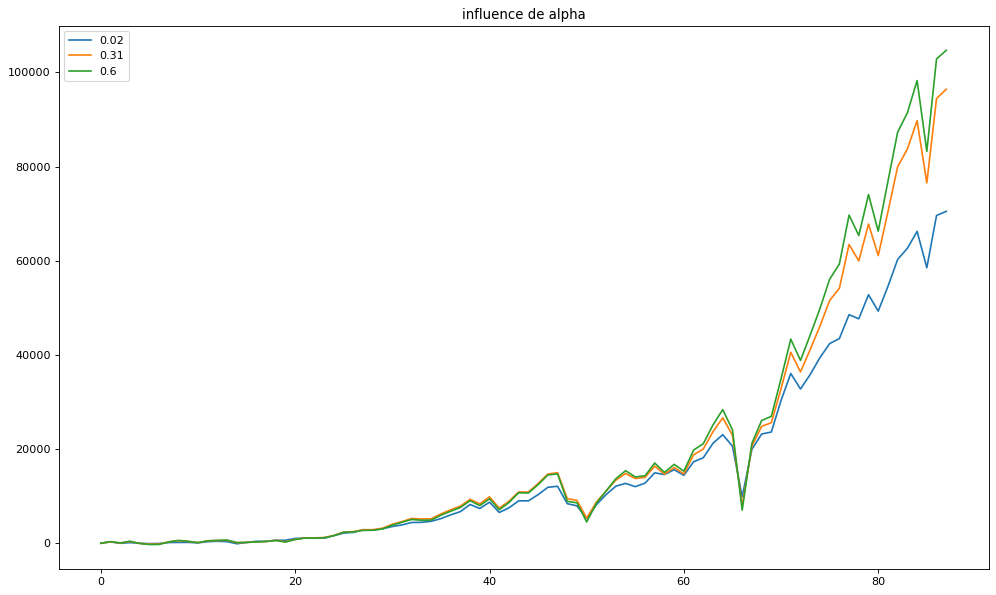

In [101]:
from matplotlib.pyplot import figure

U=[]
for x in D:
    if x not in U:
        U.append(x)


figure(figsize=(15, 9), dpi=80)

for i in range(len(U)):
    plt.plot(U[i],label=alp[i])
plt.legend()
plt.title('influence de alpha')
plt.show()

# Influence de lambda

In [102]:
D_lambd = []
D = []
l = np.array([0,0.1,1,10,100])

for j in l:
    compute_portfolio(j, alpha, Money, Pos_max_par_actif, jours_returns, periode_trades,999, gain_cible, False)

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Maximum number of function evaluations has been exceeded.
False Maximum number of function evaluations has been exceeded.
False Maximum number of function evaluations has been exceeded.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Maximum number of function evaluations has been exceeded.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Max

False Maximum number of function evaluations has been exceeded.
False Maximum number of function evaluations has been exceeded.
False Maximum number of function evaluations has been exceeded.
False Maximum number of function evaluations has been exceeded.
False Maximum number of function evaluations has been exceeded.
False Maximum number of function evaluations has been exceeded.

Argent total généré sans TC : 4562.408729970057
Coûts totaux de transaction: 649.3971983047528
Money :3913.011531665301 




Argent total généré sans TC : 0.06954199973984891
Coûts totaux de transaction: 5.667595252271537
Money :-5.598053252531689 



In [106]:
deb = '2015-02-01'.split("-")
fin = '2022-01-01'.split("-")
L1=pd.date_range(datetime(int(deb[0]),int(deb[1]),int(deb[2])),datetime(int(fin[0]),int(fin[1]),int(fin[2])), periods=min(999,int((returns_raw.shape[0]-253)/periode_trades))).to_numpy()

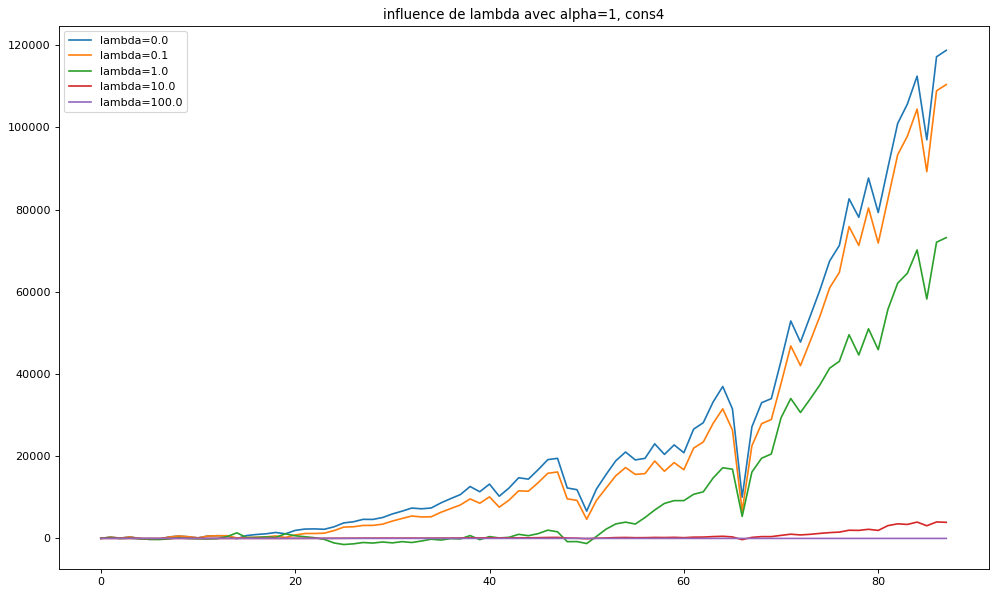

In [105]:
from matplotlib.pyplot import figure
Ul=[]
for x in D_lambd:
    if x not in Ul:
        Ul.append(x)


figure(figsize=(15, 9), dpi=80)

for i in range(len(Ul)):
    plt.plot(Ul[i],label='lambda={}'.format(l[i]))
plt.legend()
plt.title('influence de lambda avec alpha=1, cons4')
plt.show()

In [112]:
D_lambd = []
D = []
dpmax = np.array([0,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10])
for j in range (len(dpmax)):
    dPmax=dpmax[j]
    compute_portfolio(lamb, alpha, Money, Pos_max_par_actif, jours_returns, periode_trades,999, gain_cible, False)

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Maximum number of function evaluations has been exceeded.
False Maximum number of function evaluations has been exceeded.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solu

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Maximum number of function evaluations has been exceeded.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Maximum number of function evaluations has been exceeded.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Maximum number of function evaluations has been exceeded.
False Maximum number of function evaluations has been exceeded.
False Maximum number of function evaluations has been exceeded.
False Maximum number of function evaluations has been exceeded.
False Maximum number of function evaluations has been exceeded.
False Maximum number of fun

In [103]:
l

array([  0. ,   0.1,   1. ,  10. , 100. ])

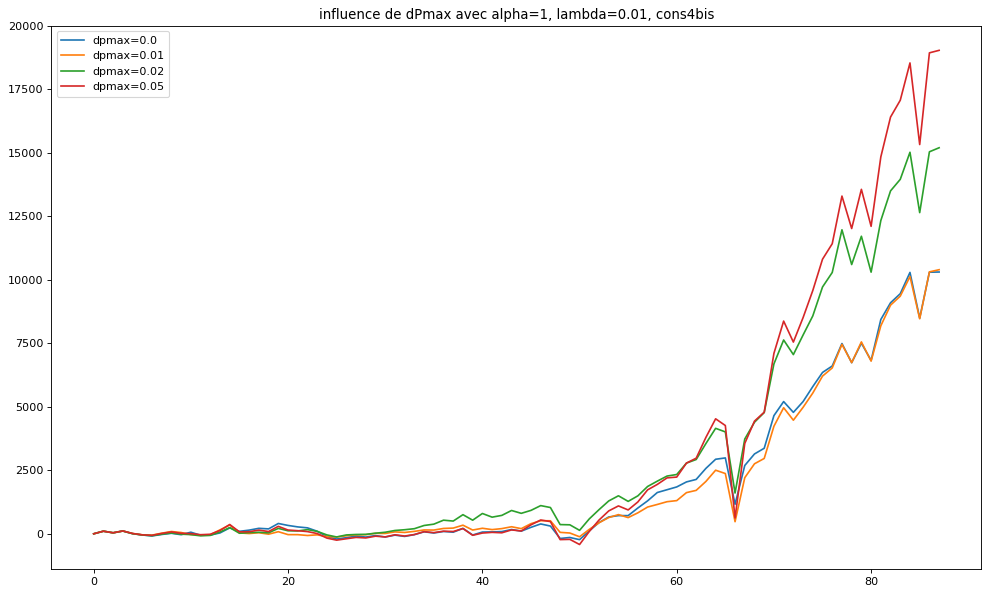

In [116]:
from matplotlib.pyplot import figure

Ul=[]
for x in D:
    if x not in Ul:
        Ul.append(x)


figure(figsize=(15, 9), dpi=80)

for i in range(len(Ul)-7):
    plt.plot(Ul[i],label='dpmax={}'.format(dpmax[i]))
plt.legend()
plt.title('influence de dPmax avec alpha=1, lambda=0.01, cons4bis')
#plt.yscale('log')
plt.show()


In [115]:
import pyfolio as pf
import warnings
from datetime import datetime


warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline


L=pd.date_range(datetime(2015,1,1),datetime(2022,1,1), periods=1+min(60,int((returns_raw.shape[0]-253)/periode_trades))).to_numpy()
#for i in range(int((all_stocks.shape[0])/periode_trades)):
 #   etape = i*periode_trades
  #  L.append(all_stocks.iloc[etape].name)

returns = pd.DataFrame()
returns['ret'] = argent_fait

returns.index = L

returns = returns['ret'].tz_localize('UTC')
#returns =returns.reindex(index=returns.index[::-1])
returns

ValueError: Length mismatch: Expected axis has 88 elements, new values have 61 elements

In [45]:
pf.create_full_tear_sheet(returns)

Start date,2015-01-01
End date,2022-01-01
Total months,2
,Backtest
Annual return,nan%
Cumulative returns,-9.113480618419805e+209%
Annual volatility,7743407.2%
Sharpe ratio,18.30
Calmar ratio,NaN
Stability,NaN
Max drawdown,-1.7500517346775912e+176%


IndexError: index -1 is out of bounds for axis 0 with size 0